In [1]:
# load necessary libraries
library(ggplot2) ## for nice drawings
library(ggforce) ## some more graphics
library(tidyr)   ## (don't forget to install.packages('tidyverse'))

## Data pre-processing
To feed the data to `ggplot`/`ggforce`'s method `geom_arc` we need to clean it up in a certain way. Let us look at the raw data:

In [2]:
df = read.csv("./refs.xmfa.backbone",sep = "\t")
str(df)

'data.frame':	27729 obs. of  30 variables:
 $ seq0_leftend  : int  0 0 0 0 0 0 -1153904 -1155194 1685700 -1157043 ...
 $ seq0_rightend : int  0 0 0 0 0 0 -1153953 -1155238 1688529 -1157091 ...
 $ seq1_leftend  : int  602660 -762711 0 0 -762709 -762708 0 0 0 0 ...
 $ seq1_rightend : int  602699 -762883 0 0 -762709 -762708 0 0 0 0 ...
 $ seq2_leftend  : int  0 0 0 0 0 0 0 -383069 0 0 ...
 $ seq2_rightend : int  0 0 0 0 0 0 0 -383118 0 0 ...
 $ seq3_leftend  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ seq3_rightend : int  0 0 0 0 0 0 0 0 0 0 ...
 $ seq4_leftend  : int  275041 0 0 0 0 0 0 0 0 0 ...
 $ seq4_rightend : int  275080 0 0 0 0 0 0 0 0 0 ...
 $ seq5_leftend  : int  -1105135 0 0 0 0 0 0 0 0 0 ...
 $ seq5_rightend : int  -1105174 0 0 0 0 0 0 0 0 0 ...
 $ seq6_leftend  : int  0 -263062 -262866 0 0 0 0 0 0 0 ...
 $ seq6_rightend : int  0 -263066 -263062 0 0 0 0 0 0 0 ...
 $ seq7_leftend  : int  0 0 0 -54486 -54483 -54482 0 0 0 0 ...
 $ seq7_rightend : int  0 0 0 -54541 -54483 -54482 0 0 0 0 ...

OK, here is the problem: we need it in the format `segment | sequence | left-end | right-end` instead. Let us reshape it. First, we will "melt" the `leftend` and `rightend` columns -- transform these into a pair of columns `col_name` (will take values `leftend` or `rightend`) and `coordinate` (will hold the coordinate value)

Note that since I don't have anything better I'll use row numbers to identify rows (whatever they are).

In [3]:
## reshape the data frame
## split row "properties" for further re-shaping

df$seg_id = rownames(df) # to identify "segments"

df_lines = df %>%
    pivot_longer(cols = c(ends_with("leftend"), ends_with("rightend")),
                 names_to = "col_name",
                 values_to = "coordinate")

df_lines$seq_id = sub("_.*","",df_lines$col_name)
df_lines$end_type = sub(".*_","",df_lines$col_name)
str(df_lines)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	831870 obs. of  5 variables:
 $ seg_id    : chr  "1" "1" "1" "1" ...
 $ col_name  : chr  "seq0_leftend" "seq1_leftend" "seq2_leftend" "seq3_leftend" ...
 $ coordinate: int  0 602660 0 0 275041 -1105135 0 0 156179 0 ...
 $ seq_id    : chr  "seq0" "seq1" "seq2" "seq3" ...
 $ end_type  : chr  "leftend" "leftend" "leftend" "leftend" ...


In [4]:
# now, just "cast" the dataframe back into the necessary structure
df_lines$col_name = NULL

df_segments = pivot_wider(df_lines, id_cols = c("seq_id","seg_id"),
                          names_from = "end_type",
                          values_from = "coordinate")

str(df_segments)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	415935 obs. of  4 variables:
 $ seq_id  : chr  "seq0" "seq1" "seq2" "seq3" ...
 $ seg_id  : chr  "1" "1" "1" "1" ...
 $ leftend : int  0 602660 0 0 275041 -1105135 0 0 156179 0 ...
 $ rightend: int  0 602699 0 0 275080 -1105174 0 0 156218 0 ...


## Data normalization

In [5]:
## normalize the data to be in [0,1]
## I'll just generate random numbers for now
## to debug the following drawing procedure

dw = read.table(header = T, text='
  seq_id seg_id leftend rightend
  seq1 1 0.0 0.3
  seq1 2 0.4 0.5
  seq1 3 0.6 0.7
  seq2 1 0.4 0.7
  seq2 2 0.8 0.9
  seq3 1 0.1 0.2
')
dw$seq_id = as.character(dw$seq_id)
dw$seg_id = as.character(dw$seg_id)

str(dw)

'data.frame':	6 obs. of  4 variables:
 $ seq_id  : chr  "seq1" "seq1" "seq1" "seq2" ...
 $ seg_id  : chr  "1" "2" "3" "1" ...
 $ leftend : num  0 0.4 0.6 0.4 0.8 0.1
 $ rightend: num  0.3 0.5 0.7 0.7 0.9 0.2


## Making nice figures, finally

In [6]:
## prepare the function
## INPUT: 
## ------
##  a dataframe with the following fields:
##  seq_id: chr, sequence id
##  seg_id: chr, segment id
##  leftend,rightend: num between 0 and 1 -- normalized coordinates
## RETURNS: a ggplot object
draw_circles <- function(df){
    df$seq_id = as.factor(df$seq_id)
    R0 = 2*length(unique(df$seq_id))
    maxval = R0+max(as.numeric(df$seq_id))*2

    plt = ggplot(df)+
        geom_arc(aes(x0=0,y0=0,start=leftend*2*pi, end = rightend*2*pi, r=R0+as.numeric(seq_id), color=seg_id),size=2)+
        geom_segment(x=-maxval,y=0, xend=maxval,yend = 0, color="gray",size=0.1)+
        geom_segment(x=0,y=-maxval, xend=0,yend = maxval, color="gray",size=0.1)+
        geom_segment(x=0,y=0, xend=0,yend = maxval, color="red",linetype="dashed",size=0.5)+
        labs(color="Segment ID")+
        xlab("")+
        ylab("")+
        scale_x_continuous(labels=NULL,breaks=NULL,limits = c(-maxval,maxval))+
        scale_y_continuous(labels=NULL,breaks=NULL,limits = c(-maxval, maxval))+
        theme_void()+
        coord_fixed()
    
    return(plt)
}

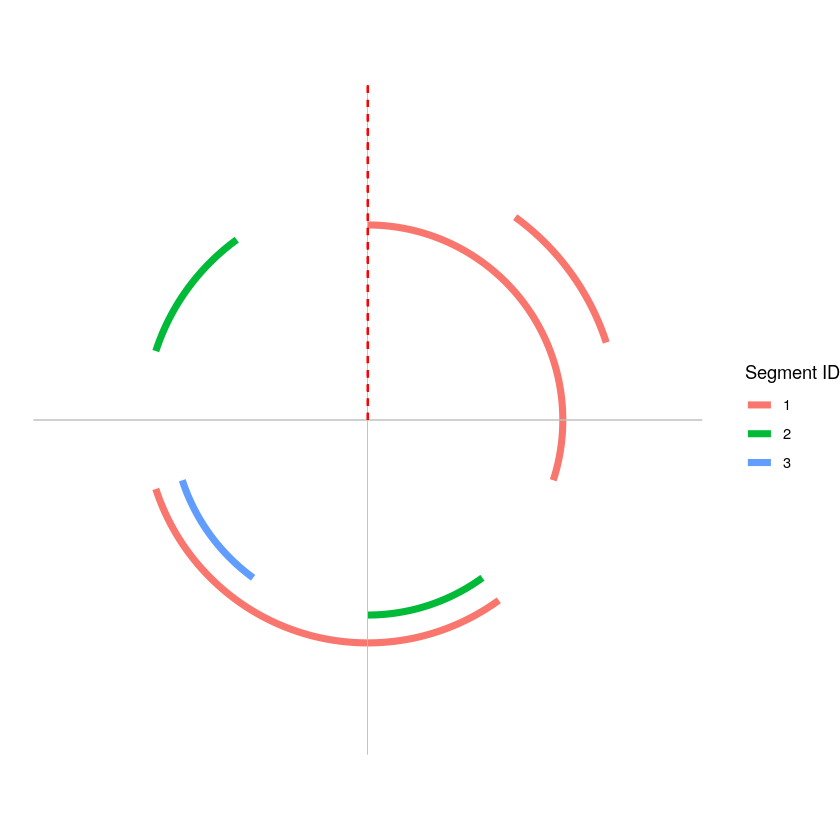

In [7]:
## test it
draw_circles(dw)